# Full-disk Radio Synthesis (Bremsstrahlung, Gyroresonance, Faraday Rotation)

In [6]:
import models.MAS.mas as mas
from sunpy.coordinates import sun
import numpy as np
from numba import njit, prange
import sunpy.sun.constants as constants
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

in_polar = False

In [ ]:
# Setup PSI model
print("Importing coronal model... ", end="")
modelName = 'hmi__med-cor-thermo2-std01__med-hel-poly-std01'
corona = mas.Model('./models/MAS/corona_cr2194/') #cr2194

# link = 'https://www.predsci.com/data/runs/cr2247-high/hmi_mast_mas_std_0201/' #cr2247
# corona = psi.Model('./corona_cr2247/')
print("done")

# Setup observer
print("Initializing observer and image plane... ", end="")
crn= sun.carrington_rotation_number('2017-08-21T12:00:00.000') #2247
crt = sun.carrington_rotation_time(crn)
obsLon = sun.L0(crt).rad
obsLat = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc = sun.angular_radius(crt).value
rObs = Obs_Sun_AU * constants.astronomical_unit.value/constants.radius.value
thetaObs = np.pi / 2 - obsLat
phiObs = obsLon

# Create image
rsunarc = 960
arcsamp = 20.
arc = np.linspace(-3 * rsunarc, 3 * rsunarc, int(6 * rsunarc / arcsamp))
zza, yya = np.meshgrid(arc, arc, indexing='ij')
zza = np.flipud(zza)
mask_ondisk = (np.hypot(zza, yya) > rsunarc).astype(float)

if in_polar:
    arc_rings = np.linspace(0, 3 * rsunarc, int(6 * rsunarc / arcsamp))
    arc_points = np.linspace(0, 2 * np.pi, int(2 * np.pi * rsunarc / arcsamp), endpoint=False) # change the two 2s to 4s for twice around
    zza, yya = np.meshgrid(arc_rings, arc_points, indexing='ij')
    zza, yya = zza * np.cos(yya), zza * np.sin(yya)
    mask_ondisk = (np.hypot(zza, yya) > rsunarc).astype(float)

# Project to solar tangent plane
yy = rObs * np.tan(np.deg2rad(yya / 3600.))
zz = rObs * np.tan(np.deg2rad(zza / 3600.))
rr = np.hypot(yy, zz)
xx = np.zeros_like(rr)
xx[rr < 1] = np.sqrt(1 - rr[rr < 1]**2)
print("done")

# Create rays
print("Creating rays through image plane... ", end="")
rot = euler_ry(thetaObs - np.pi/2) @ euler_rz(phiObs)
starts = (rot @ np.stack([xx.ravel(), yy.ravel(), zz.ravel()])).T
obs_vec = rObs * np.array([
    np.sin(thetaObs) * np.cos(phiObs),
    np.sin(thetaObs) * np.sin(phiObs),
    np.cos(thetaObs)
])
los = obs_vec - starts
los /= np.linalg.norm(los, axis=1, keepdims=True)

start_r = 1.0 # start this many solar radii from sun's center
deltaR_forward = corona.rs - start_r
deltaR_forward = deltaR_forward[deltaR_forward >= 0]
deltaR_bidirectional = np.cumsum(np.diff(corona.rs))
deltaR_bidirectional = np.hstack([-deltaR_bidirectional[::-1], deltaR_bidirectional])
deltaR = np.zeros((len(deltaR_bidirectional), starts.shape[0]))
on_disk = np.linalg.norm(starts, axis=1) <= 1.0
deltaR[:len(deltaR_forward), on_disk] = deltaR_forward[:, None]
deltaR[:len(deltaR_bidirectional), ~on_disk] = deltaR_bidirectional[:, None]
rays_xyz = starts[None] + deltaR[:, :, None] * los[None]

# Convert to spherical coordinates
r = np.linalg.norm(rays_xyz, axis=2)
theta = np.arccos(rays_xyz[:, :, 2] / r)
phi = np.mod(np.arctan2(rays_xyz[:, :, 1], rays_xyz[:, :, 0]), 2 * np.pi)
rays_sph = np.stack([phi, theta, r], axis=-1).reshape(-1, 3)
print('done')

# Interpolation
print("Interpolating plasma and magnetic field values... ", end="")
def interp(field, name):
    print(f"({name}) ", end="")
    return rgi(
        (corona.phis, corona.thetas, corona.rs),
        field,
        method='linear',
        fill_value=0.0,
        bounds_error=False
    )(rays_sph).reshape(r.shape)

bx_rays = interp(corona.bx, "bx")
by_rays = interp(corona.by, "by")
bz_rays = interp(corona.bz, "bz")
ne_rays = interp(corona.ne, "density")
temp_rays = interp(corona.temp, "temp")
print("done")

# B-field projections
print("Projecting B-fields along LOS... ", end="")
bvec = np.stack([bx_rays, by_rays, bz_rays], axis=-1)
lvec = rays_xyz / (np.linalg.norm(rays_xyz, axis=2, keepdims=True) + 1e-15)
blos_rays = np.sum(bvec * lvec, axis=2)
btot_rays = np.linalg.norm(bvec, axis=2)

# Step sizes
dray = np.linalg.norm(np.diff(rays_xyz, axis=0), axis=2) * constants.radius.value * 100.  # solar radius in cm
print("done")

# constants
v = 2e7
kb = 1.3807e-16
cc = 299792458 * 100
tb_to_jansky = lambda t: 2*kb*t*v**2/cc**2*(arcsamp / 206265)**2*1e23

Importing coronal model... done
Initializing observer and image plane... done
Creating rays through image plane... done
Interpolating plasma and magnetic field values... (bx) (by) (bz) (density) (temp) done
Projecting B-fields along LOS... done


In [9]:
%%script true
import plotly.graph_objects as go
import plotly.express as px
import random

layout = go.Layout(
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(layout = layout)

u_s = np.linspace(0, 2*np.pi, 50)
v_s = np.linspace(0, np.pi, 25)
x_s = 1*np.outer(np.cos(u_s), np.sin(v_s))
y_s = 1*np.outer(np.sin(u_s), np.sin(v_s))
z_s = 1*np.outer(np.ones_like(u_s), np.cos(v_s))

fig.add_trace(go.Surface(
    x=x_s, y=y_s, z=z_s,
    colorscale=[[0, 'red'], [1, 'red']],
    opacity=0.1,
    showscale=False,
    name='Sun'
))

# fig.add_trace(go.Scatter3d(
#     x=[obs_vec[0]], y=[obs_vec[1]], z=[obs_vec[2]],
#     mode='markers',
#     marker=dict(size=2, color='blue'),
#     showlegend=False
# ))

# for j in range(0, rays_xyz.shape[1], 5000):
#     r = random.randint(0, 255)
#     g = random.randint(0, 255)
#     b = random.randint(0, 255)
#     c = f'rgb({r},{g},{b})'
#     start_points = rays_xyz[0, j, :]
#     end_points = rays_xyz[-90, j, :]
#     fig.add_trace(go.Scatter3d(
#         x=[start_points[0], end_points[0]],
#         y=[start_points[1], end_points[1]],
#         z=[start_points[2], end_points[2]],
#         mode='lines',
#         marker=dict(size=2, color=c),
#         opacity=1,
#         showlegend=False,
#     ))

for j in range(0, rays_xyz.shape[0] - 21, 20):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    c = f'rgb({r},{g},{b})'
    for i in range(0, rays_xyz.shape[1] , 4000):
        start_points = rays_xyz[0, j, :]
        end_points = rays_xyz[-1, j, :]
        fig.add_trace(go.Scatter3d(
            x=[rays_xyz[j, i, 0]],
            y=[rays_xyz[j, i, 1]],
            z=[rays_xyz[j, i, 2]],
            mode='markers',
            marker=dict(size=2, color=c),
            opacity=1,
            showlegend=False,
        ))
        fig.add_trace(go.Scatter3d(
            x=[rays_xyz[j, i, 0], rays_xyz[j + 20, i, 0]],
            y=[rays_xyz[j, i, 1], rays_xyz[j + 20, i, 1]],
            z=[rays_xyz[j, i, 2], rays_xyz[j + 20, i, 2]],
            mode='lines',
            line=dict(color='blue', width=2),
            opacity=0.3,
            showlegend=False,
        ))
# for i in tqdm.tqdm(range(0, rays_xyz.shape[1], 5000)):
#     fig.add_trace(go.Scatter3d(
#         x=[xObs, rays_xyz[0, :, :][i][0]],
#         y=[yObs, rays_xyz[0, :, :][i][1]],
#         z=[zObs, rays_xyz[0, :, :][i][2]],
#         mode='lines',
#         line=dict(color='blue', width=2),
#         opacity=0.3,
#         showlegend=False,
#     ))

fig.update_layout(
    scene=dict(
        xaxis=dict(title='X (solar radii)'),
        yaxis=dict(title='Y (solar radii)'),
        zaxis=dict(title='Z (solar radii)'),
        aspectmode='data',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    autosize=True,
    scene_camera=dict(
        projection=dict(type='orthographic')
    )
)

Couldn't find program: 'true'


In [10]:
@njit
def for_gyrores(v, s, ne, temp, theta_rad, dl):
    # params: wave freq, harmonic n, ion density, temp, angle between B and k, line of sight component
    # return: x and o mode components of optical depth

    if s < 1 or s > 8:
        return 0.0, 0.0
    me = 9.11e-28 # g
    kB = 1.38e-16 # erg/K
    cc = 3.0e10 # cm/s
    bb = v / (2.8e6 * s)  # Gauss
    fgyro = 2.8e6 * bb # Hz
    fplasma = 8980.0 * np.sqrt(ne)  # Hz

    Y = fgyro / v
    X = (fplasma / v)**2
    delta = np.sqrt((Y * np.sin(theta_rad))**4/4.0 + (1.0 - X)**2 * (Y*np.cos(theta_rad))**2)
    calc_tee = lambda dsgn: (-(Y * np.sin(theta_rad))**2 / 2.0 - dsgn*delta) / (Y * (1.0 - X)*np.cos(theta_rad))

    coeff = (np.pi**2 / 2.0) * 8.064e7 * ne * dl / v / cc
    factorials = (1.0, 1.0, 2.0, 6.0, 24.0, 120.0, 720.0, 5040.0)
    base_factor = coeff * s**2 / factorials[s - 1] * (s**2 * np.sin(theta_rad)**2 * kB * temp / (2.0 * me * cc**2))**(s - 1)

    calc_optical_depth = lambda tee: base_factor * ((1. + tee * np.cos(theta_rad))**2 + (temp / (5.9413e9 * tee))**2) / (1. + tee**2)
    calc_gyro = lambda mode: calc_optical_depth(calc_tee(-1.0 if mode == 'x' else 1.0))

    taux = calc_gyro('x') if s != 1 else 0.0
    tauo = calc_gyro('o')
    return taux, tauo

@njit
def calc_brem_integrands(blos, ne, Te, dl, v):
    f = 2.8e6 * blos/v
    dtau = 0.2 * ne**2/v**2*Te**(-3./2.)*dl
    dtaur, dtaul = dtau/(1.-f)**2, dtau/(1.+f)**2
    return dtaur, dtaul

@njit
def calc_gyro_integrands(blos, btot, ne, Te, dl, v):
    if btot > 0:
        s = int(v / (2.8e6 * btot))
        if 1 <= s <= 8:
            theta_rad = np.arccos(min(max(blos / btot, -1.0), 1.0))
            taux, tauo = for_gyrores(v, s, ne, Te, theta_rad, dl)
            if blos < 0:
                taux, tauo = tauo, taux
            return taux, tauo
    return 0., 0.

@njit
def calc_radiative_transfer(dtaur, dtaul, Te, Tbr, Tbl):
    Tbr, Tbl = Tbr*np.exp(-dtaur)+Te*(1.-np.exp(-dtaur)), Tbl*np.exp(-dtaul)+Te*(1.-np.exp(-dtaul))
    return Tbr, Tbl

@njit(parallel=True)
def radio_integrate(temp_rays, btot_rays, blos_rays, ne_rays, dray, v, dogyro = False):
    nrays = dray.shape[1]
    ray_npt = dray.shape[0]
    FR = np.zeros((2, nrays)) # faraday rotation (angle and dispersion measure)
    IV = np.zeros((2, nrays)) # stokes IV
    THK = np.zeros(nrays) # depths of optical thickness
    for i in prange(nrays):
        Tbr = Tbl = 3.
        rm = dm = 0.
        taur = taul = 0.
        depth = 0.
        for j in prange(ray_npt - 1):
            dl = np.abs(dray[j, i])
            if dl == 0:
                continue
            depth += dl
            Te = temp_rays[j, i]
            Te = max(Te, 3)
            blos = blos_rays[j, i]
            btot = btot_rays[j, i]
            ne = ne_rays[j, i]

            dtaur, dtaul = calc_brem_integrands(blos, ne, Te, dl, v)
            if dogyro:
                taux, tauo = calc_gyro_integrands(blos, btot, ne, Te, dl, v)
                dtaur += taux
                dtaul += tauo
            
            taul += dtaul
            taur += dtaur
            Tbr, Tbl = calc_radiative_transfer(dtaur, dtaul, Te, Tbr, Tbl)

            # faraday int
            rm += ne * blos * dl # rotation measure
            dm += ne*dl # dispersion measure
            if not THK[i] and (taur + taul)/2. >= 1.:
                THK[i] = depth
        # FR[0, i] = 2.63e-13 * rm # rotation measure
        FR[0, i] = 2.63e-13 * rm * (3e8 / v)**2 # angle of rotation
        FR[1, i] = dm # dispersion measure
        I = (Tbr + Tbl) / 2.
        V = (Tbr - Tbl) / 2.
        IV[0, i] = I
        IV[1, i] = V
    return IV, FR, THK

v = 17e9

print('Integrating only bremsstrahlung... ', end="")
IV0, _, _ = radio_integrate(temp_rays, btot_rays, blos_rays, ne_rays, dray, v, False)
IV0 = IV0.reshape(2, *yya.shape)
print('done')

print('Extending for gyrosynchrotron...', end='')
IV, FR, THK = radio_integrate(temp_rays, btot_rays, blos_rays, ne_rays, dray, v, True)
IV = IV.reshape(2, *yya.shape)
print('done')

print(f"{np.round(np.count_nonzero(IV0[0].flatten() != IV[0].flatten())/len(IV[0].flatten())*100)}% impact of gyro particles on image")

FR = FR.reshape(2, *yya.shape)
THK = THK.reshape(*yya.shape)

Integrating only bremsstrahlung... done
Extending for gyrosynchrotron...done
0.0% impact of gyro particles on image


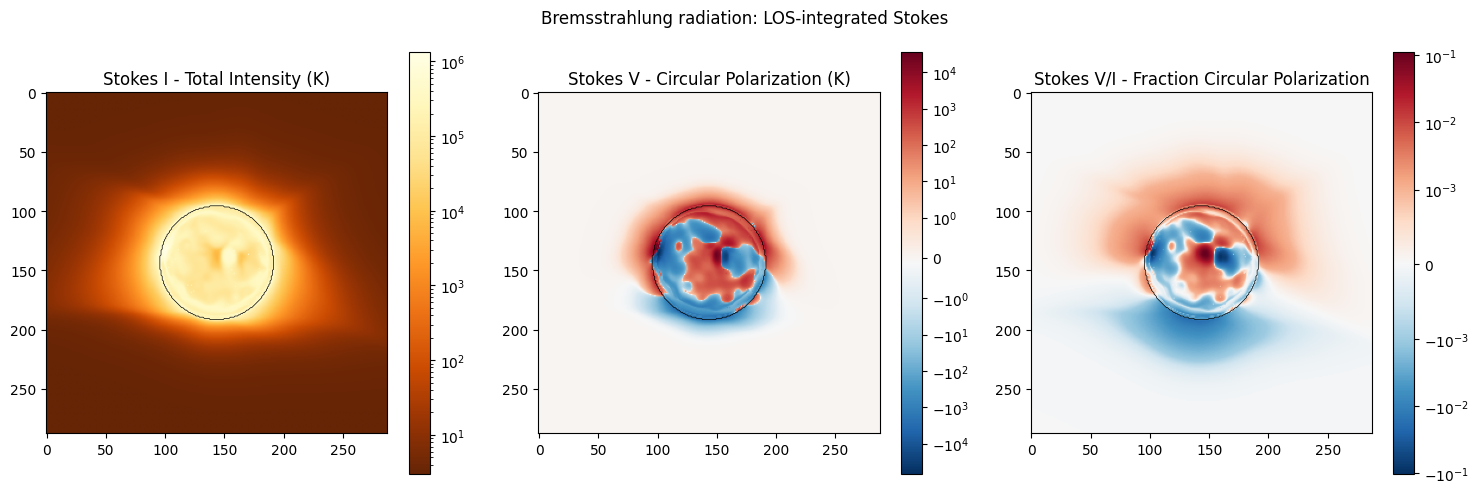

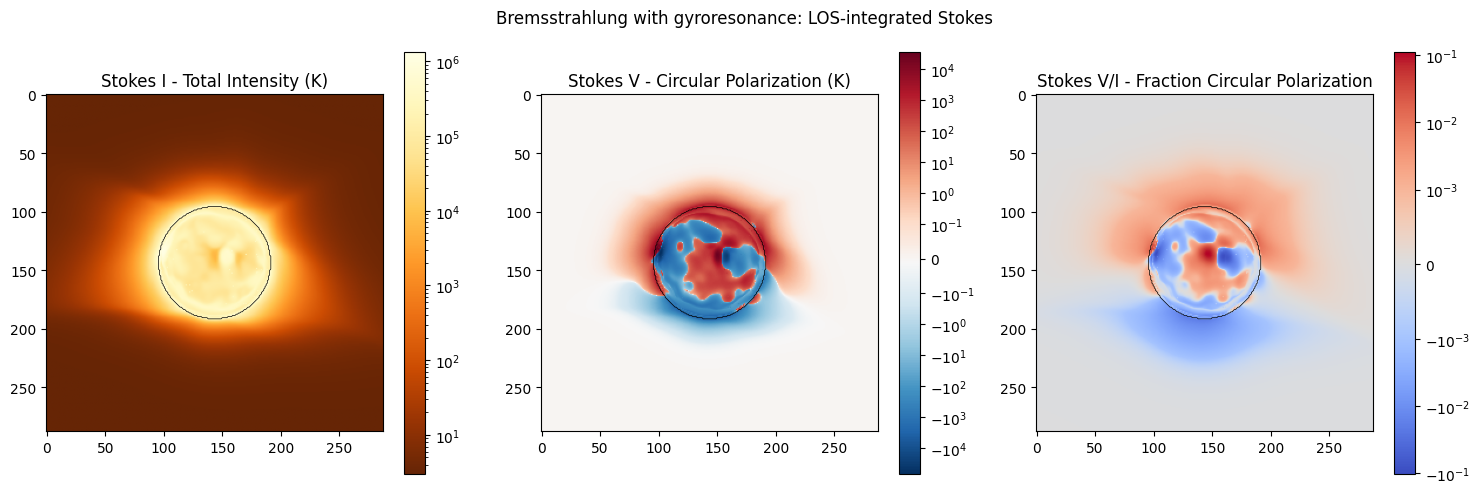

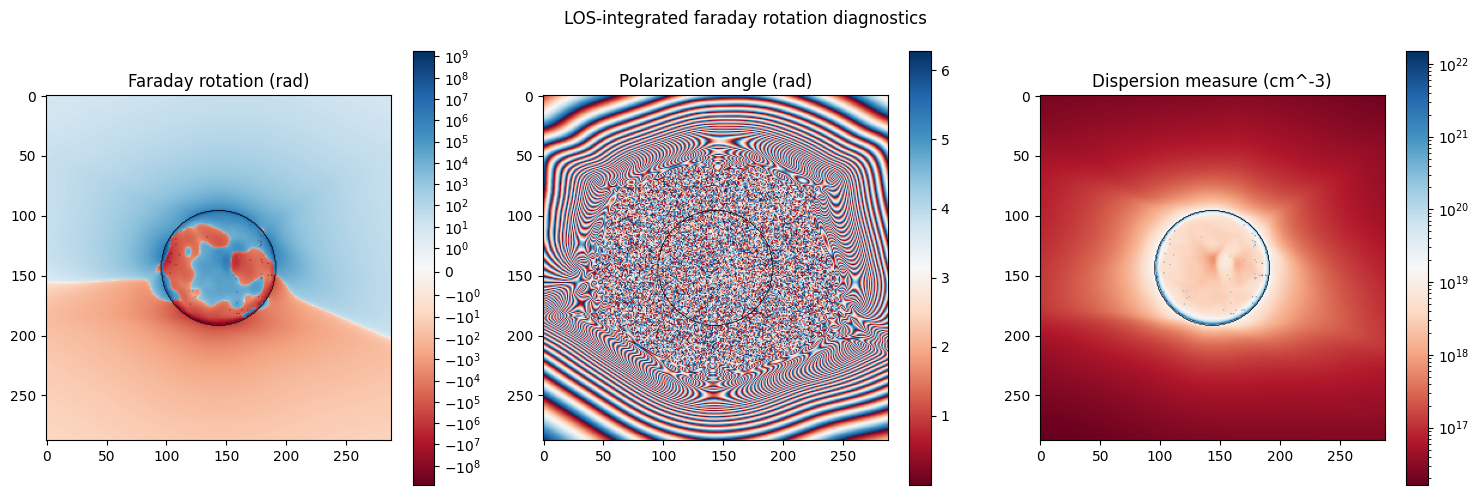

In [ ]:
unit = "K"

I0, V0 = tb_to_jansky(IV0) if unit == "Jy" else IV0 if unit == "K" else 0.
I, V = tb_to_jansky(IV) if unit == "Jy" else IV if unit == "K" else 0.
ex_mask = lambda arr: np.where(np.abs(arr) > 1, 0, arr)
comp = lambda arr0, arr1: [np.min([*arr0.flatten(), *arr1.flatten()]), np.max([*arr0.flatten(), *arr1.flatten()])]
minI, maxI = comp(I, I0)
minV, maxV = comp(V, V0)


# Brem only
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Bremsstrahlung radiation: LOS-integrated Stokes')
im0 = axs[0].imshow(I0,cmap = 'YlOrBr_r', aspect='equal',norm = LogNorm())
axs[0].set_title("Stokes I - Total Intensity (K)")
axs[0].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(V0,cmap = 'RdBu_r', aspect='equal', norm=SymLogNorm(1))
axs[1].set_title("Stokes V - Circular Polarization (K)")
axs[1].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
fig.colorbar(im1, ax=axs[1])
im1 = axs[2].imshow(V0/I0,cmap = 'RdBu_r', aspect='equal', norm=SymLogNorm(0.001))
axs[2].set_title("Stokes V/I - Fraction Circular Polarization")
axs[2].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
fig.colorbar(im1, ax=axs[2])
plt.tight_layout()
plt.show()

# Gyro integrated
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Bremsstrahlung with gyroresonance: LOS-integrated Stokes')
im0 = axs[0].imshow(I,cmap = 'YlOrBr_r', aspect='equal',norm = LogNorm())
axs[0].set_title(f"Stokes I - Total Intensity ({unit})")
axs[0].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(V,cmap = 'RdBu_r', aspect='equal', norm=SymLogNorm(0.1))
axs[1].set_title(f"Stokes V - Circular Polarization ({unit})")
axs[1].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
fig.colorbar(im1, ax=axs[1])
im1 = axs[2].imshow(V/I,cmap = 'RdBu_r', aspect='equal', norm=SymLogNorm(0.001))
axs[2].set_title("Stokes V/I - Fraction Circular Polarization")
axs[2].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
fig.colorbar(im1, ax=axs[2])
plt.tight_layout()
plt.show()

# Faraday rotation plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('LOS-integrated faraday rotation diagnostics')
axs[0].set_title('Faraday rotation (rad)')
im0 = axs[0].imshow(FR[0], cmap='RdBu', aspect='equal', norm=SymLogNorm(1))
axs[0].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
plt.colorbar(im0, ax = axs[0])
axs[1].set_title('Polarization angle (rad)')
im1 = axs[1].imshow(FR[0] % (2*np.pi), cmap='RdBu', aspect='equal')
axs[1].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
plt.colorbar(im1, ax = axs[1])
axs[2].set_title('Dispersion measure (cm^-3)')
im2 = axs[2].imshow(FR[1], cmap='RdBu', aspect='equal', norm=LogNorm())
axs[2].contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
plt.colorbar(im2, ax = axs[2])
plt.tight_layout()
plt.show()

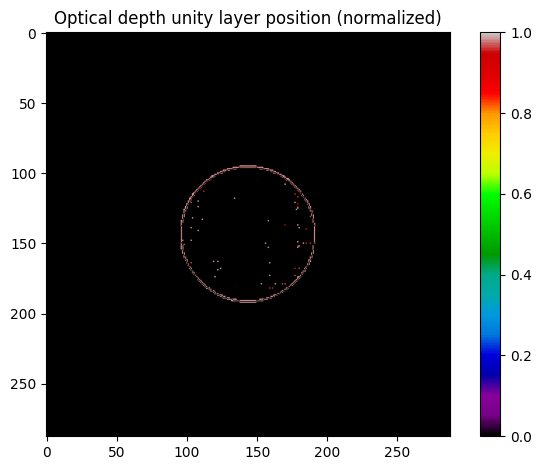

In [170]:
# Optical thickness plot
plt.figure()
plt.title('Optical depth unity layer position (normalized)')
THKC = THK
im0 = plt.imshow((THKC - np.min(THKC))/(np.max(THKC) - np.min(THKC)), cmap='nipy_spectral', aspect='equal')
plt.contour(mask_ondisk, levels=[0.5], colors='black', linewidths=0.5)
plt.colorbar(im0)
plt.tight_layout()
plt.show()

# Optical Depth Calculations

C:\Users\cgraham\AppData\Roaming\Python\Python313\site-packages\numba\parfors\parfor_lowering.py:1205: NumbaParallelSafetyWarning:

Variable pol.3 used in parallel loop may be written to simultaneously by multiple workers and may result in non-deterministic or unintended results.

File "..\..\..\AppData\Local\Temp\ipykernel_20696\1270250783.py", line 33:
<source missing, REPL/exec in use?>




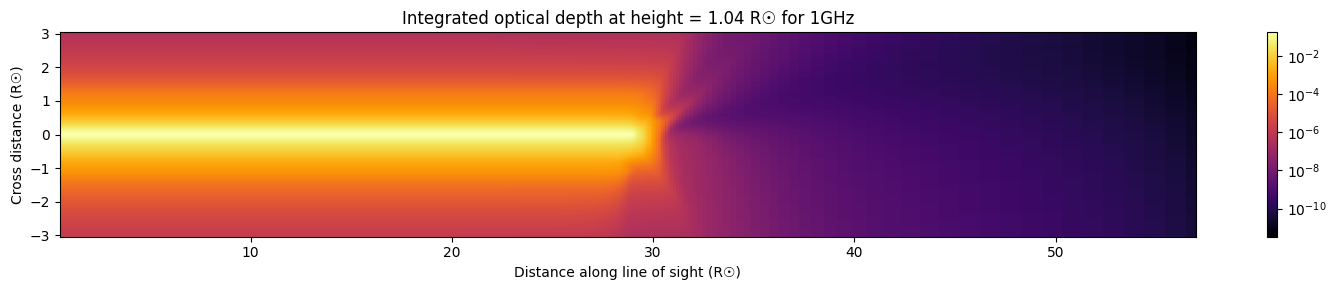

In [171]:
# distance along LOS vs. arc distance (side-to-side)

v = 1000e6
height = 1.04 # numer of solar radii above/below sun's center
V = np.logspace(5, 10, 15)
dogyro = True
in_solarradii = True

format_freq = lambda f: f"{int(f//10**(3*(k:=int(np.log10(f)//3))))}{' kMGT'[k].replace(' ', '')}Hz"

H, W = yya.shape
row_index = np.argmin(np.abs(zz[:, 0] - height))
start = row_index*W
end = start + W
mask = np.arange(H*W).reshape(H, W)[row_index, :]
hslicer = lambda rays: rays[:, mask]

if in_polar:
    # TESTING POLAR
    height_arcsec = np.rad2deg(np.arctan(height / rObs)) * 3600.
    row_index = np.argmin(np.abs(zza[:, 0] - height_arcsec))
    mask = np.arange(H*W).reshape(H, W)[row_index, :]
    hslicer = lambda rays: rays[:, mask]
    # DONE TESTING POLAR

@njit(parallel=True)
def radio_integrate_slice(temp_rays, btot_rays, blos_rays, ne_rays, dray, v, dogyro = False):
    nrays = dray.shape[1]
    ray_npt = dray.shape[0]
    taus = np.zeros((ray_npt, nrays))
    depths = np.zeros((ray_npt, nrays))
    pols = np.zeros((ray_npt, nrays))
    for i in prange(nrays):
        depth = tau = pol = 0.
        Tbr = Tbl = 3.
        for j in range(ray_npt - 1):
            dl = np.abs(dray[j, i])
            # if dl < 1e8:
            #     taus[j, i] = 0
            #     depths[j, i] = depths[j-1, i] + dl
            #     continue
            Te = temp_rays[j, i]
            blos = blos_rays[j, i]
            btot = btot_rays[j, i]
            ne = ne_rays[j, i]

            dtaur, dtaul = calc_brem_integrands(blos, ne, Te, dl, v)
            if dogyro:
                taux, tauo = calc_gyro_integrands(blos, btot, ne, Te, dl, v)
                dtaur += taux
                dtaul += tauo
            
            Tbr, Tbl = calc_radiative_transfer(dtaur, dtaul, Te, Tbr, Tbl)

            depth += dl
            tau += (dtaur + dtaul)/2
            pol += (dtaur - dtaul)/2
            taus[j, i] = tau
            depths[j, i] = depth
            pols[j, i] = pol
        depths[ray_npt - 1, i] = depth
        taus[ray_npt - 1, i] = tau
        pols[ray_npt - 1, i] = pol
    return taus, depths, pol

taus, depths, _ = radio_integrate_slice(hslicer(temp_rays), hslicer(btot_rays), hslicer(blos_rays), hslicer(ne_rays), hslicer(dray), v, dogyro)
depths = np.flip(depths, axis=0)
if in_solarradii:
    depths = depths / constants.radius.value / 100.

arc_axis = yy.flatten()[mask]

# TESTING POLAR
if in_polar:
    radius = zza[row_index, 0]
    angles = np.linspace(0, 4*np.pi, W, endpoint=False)
    arc_axis = radius * angles
    if in_solarradii:
        arc_axis = np.tan(np.deg2rad(arc_axis / 3600.)) * rObs
# DONE TESTING POLAR

if not in_solarradii:
    arc_axis *= constants.radius.value * 100.

ray_npt, nrays = taus.shape
arc_axis_2d = np.tile(arc_axis[:, np.newaxis], (1, ray_npt))

plt.figure(figsize=(15, 3))
pcm = plt.pcolormesh(
    depths.T,
    arc_axis_2d,
    taus.T,
    shading='auto',
    cmap='inferno',
    norm=LogNorm()
)
contour = plt.contour(
    depths.T,
    arc_axis_2d,
    taus.T,
    levels=[1.],
    colors='white',
    linewidths=1.5
)
plt.clabel(contour, fmt='τ=1', colors='white')
plt.xlabel(f'Distance along line of sight ({'R☉' if in_solarradii else 'cm'})')
plt.ylabel(f'Cross distance ({'R☉' if in_solarradii else 'cm'})')
plt.title(f'Integrated optical depth at height = {height} R☉ for {format_freq(v)}')
plt.colorbar(pcm)
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

C:\Users\cgraham\AppData\Local\Temp\ipykernel_20696\2337278332.py:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



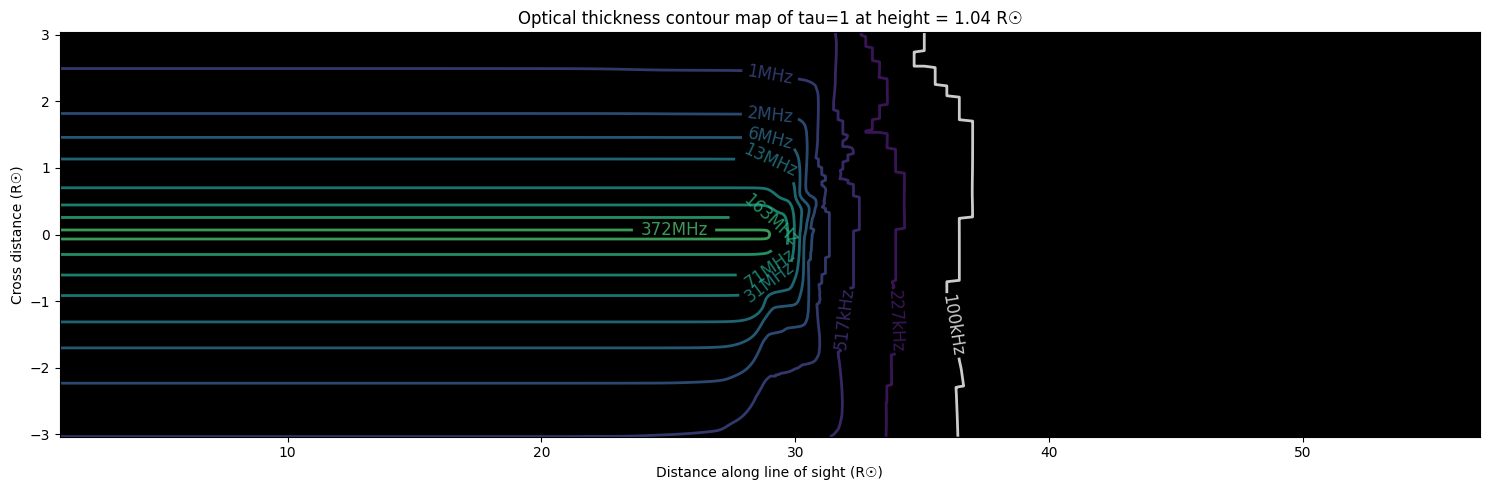

In [172]:
ray_npt, nrays = hslicer(temp_rays).shape
colors = plt.cm.get_cmap('viridis')(np.linspace(0, 1, len(V)))

plt.figure(figsize=(15, 5))
plt.gca().set_facecolor('black')

all_taus, all_depths, all_pols = [], [], []
for i, v in enumerate(V):
    taus, depths, pols = radio_integrate_slice(
        hslicer(temp_rays),
        hslicer(btot_rays),
        hslicer(blos_rays),
        hslicer(ne_rays),
        hslicer(dray),
        v,
        dogyro
    )
    depths = np.flip(depths, axis=0)
    if in_solarradii:
        depths = depths / constants.radius.value / 100.
    all_taus.append(taus)
    all_depths.append(depths)
    all_pols.append(pols)
    contour = plt.contour(
        depths.T,
        arc_axis_2d,
        taus.T,
        levels=[1.0],
        colors='white' if v % 10 == 0 else colors[i],
        linewidths=2,
        alpha=0.8
    )
    plt.clabel(contour, fmt=f'{format_freq(v)}', inline=True, fontsize=12, inline_spacing=0)

plt.xlabel(f'Distance along line of sight ({'R☉' if in_solarradii else 'cm'})')
plt.ylabel(f'Cross distance ({'R☉' if in_solarradii else 'cm'})')
plt.title(f'Optical thickness contour map of tau=1 at height = {height} R☉')
plt.gca().set_aspect('auto')
plt.tight_layout()
plt.show()

C:\Users\cgraham\AppData\Local\Temp\ipykernel_20696\2381180265.py:38: UserWarning:

Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1500x500 with 6 Axes> which fig.colorbar is called on.

C:\Users\cgraham\AppData\Local\Temp\ipykernel_20696\2381180265.py:42: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



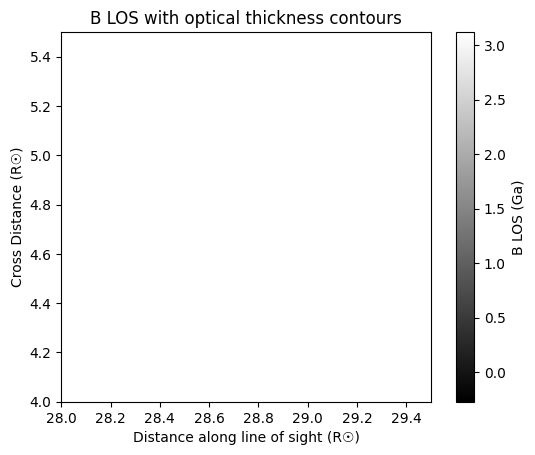

[]


In [173]:
pcm = plt.pcolormesh(
    depths.T,
    arc_axis_2d,
    hslicer(blos_rays).T[:, :-1],
    shading='auto',
    cmap='inferno',
    norm=LogNorm()
)

plt.xlim(28, 29.5)
plt.ylim(4, 5.5)

labels_with_pos = []
for i, v in enumerate(V):
    contour = plt.contour(
        all_depths[i].T,
        arc_axis_2d,
        all_taus[i].T,
        levels=[1.0],
        colors='white',
        linewidths=2,
        alpha=0.8
    )
    for path in contour.get_paths():
        vertices = path.vertices
        if len(vertices) == 0:
            continue
        min_x_idx = np.argmin(vertices[:, 0])
        min_x = vertices[min_x_idx, 0]
        y_pos = vertices[min_x_idx, 1]
        if (min_x >= 27.5 and min_x <= 29.5):
            labels_with_pos.append(format_freq(v))
    plt.clabel(contour, fmt=f'{format_freq(v)}', inline=True, fontsize=10, inline_spacing=2)

plt.gca().set_aspect('equal')
plt.title('B LOS with optical thickness contours')
plt.ylabel(f'Cross Distance ({'R☉' if in_solarradii else 'cm'})')
fig.colorbar(pcm, label='B LOS (Ga)')

plt.xlabel(f'Distance along line of sight ({'R☉' if in_solarradii else 'cm'})')
pcm.set_cmap('gray')
pcm.set_norm(Normalize())
plt.show()
print(labels_with_pos)

C:\Users\cgraham\AppData\Local\Temp\ipykernel_20696\1861112686.py:51: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



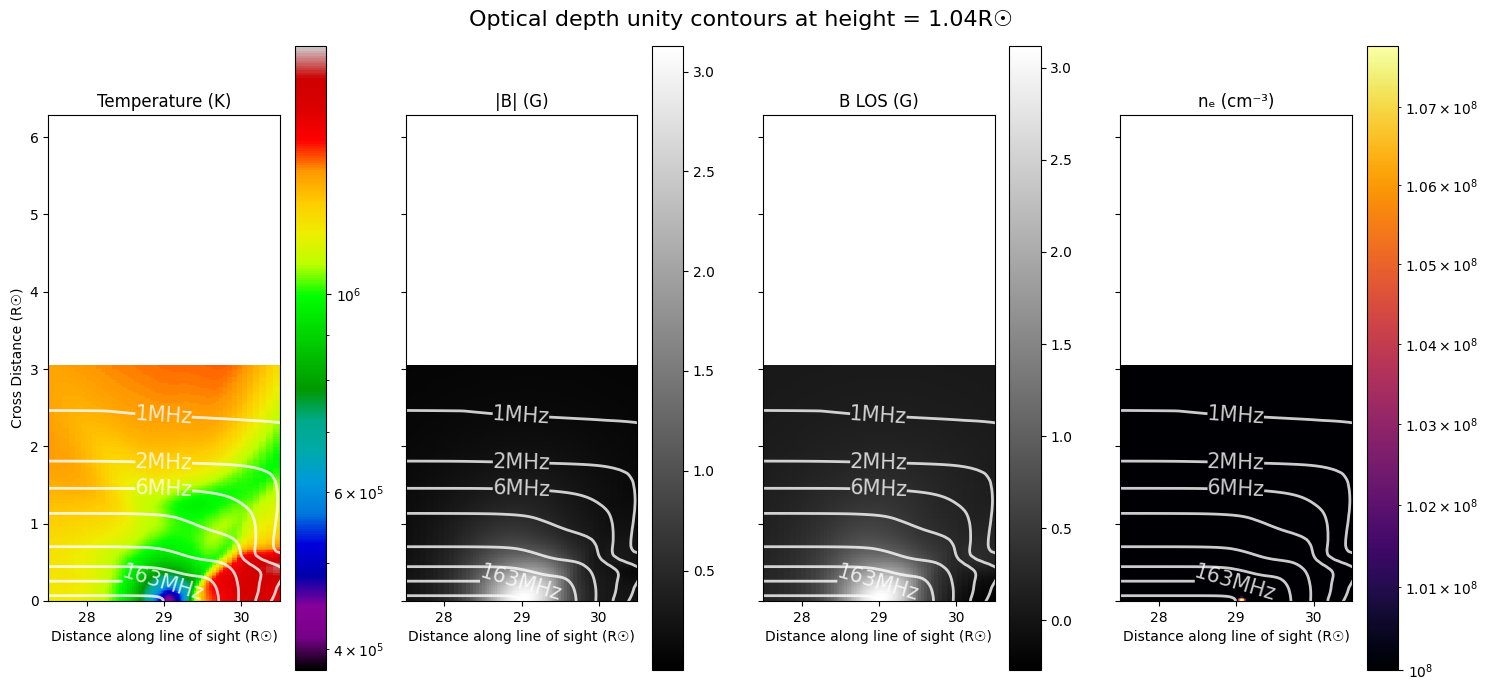

In [174]:
fig, axes = plt.subplots(1, 4, figsize=(15, 7), sharey=True, sharex = False)

fields = {
    'Temperature (K)': hslicer(temp_rays),
    '|B| (G)': hslicer(btot_rays),
    'B LOS (G)': hslicer(blos_rays),
    'nₑ (cm⁻³)': hslicer(ne_rays),
    'Circular polarization': all_pols[0]
}

pcms = []
for ax, (label, data) in zip(axes, fields.items()):
    pcm = ax.pcolormesh(
        depths.T,
        arc_axis_2d,
        data.T[:, :-1],
        shading='auto',
        cmap='inferno',
        norm=LogNorm()
    )
    pcms.append(pcm)

    if in_solarradii:
        ax.set_xlim(27.5, 30.5)
        ax.set_ylim(0, 2*np.pi)
    else:
        ax.set_xlim(1e12, 3e12)
    
    for i, v in enumerate(V):
        contour = ax.contour(
            all_depths[i].T,
            arc_axis_2d,
            all_taus[i].T,
            levels=[1.0],
            colors='white',
            linewidths=2,
            alpha=0.8
        )
        ax.clabel(contour, fmt=f'{format_freq(v)}', inline=True, fontsize=15, inline_spacing=2)
    ax.set_aspect('equal')
    ax.set_title(label)
    ax.set_xlabel(f'Distance along line of sight ({'R☉' if in_solarradii else 'cm'})')
    fig.colorbar(pcm, ax=ax)

axes[0].set_ylabel(f'Cross Distance ({'R☉' if in_solarradii else 'cm'})')
pcms[0].set_norm('log')
pcms[0].set_cmap('nipy_spectral')
pcms[1].set_cmap('gray')
pcms[1].set_norm(Normalize())
pcms[2].set_cmap('gray')
pcms[2].set_norm(Normalize())
pcms[3].set_cmap('inferno')
pcms[3].set_norm(LogNorm(vmin=1e8))
dogyro = False
fig.suptitle(f'Optical depth unity contours at height = {height}R☉ {'with gyroresonance' if dogyro else ''}', fontsize=16)
plt.tight_layout()
plt.show()

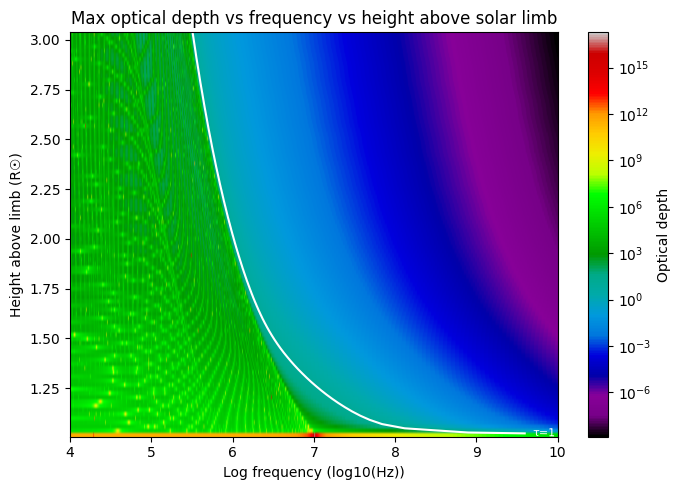

In [175]:
V = np.linspace(4, 10, 1000)
dogyro = False

H, W = yya.shape
centeridx = W // 2
heights = zz[:, centeridx]
valid_rows = np.where(heights > 1.0)[0]
heights = heights[valid_rows]
ray_indices = valid_rows * W + centeridx

tau_max_vs_freq = np.zeros((len(V), len(ray_indices)))
for i, v in enumerate(V):
    taus, _, _ = radio_integrate_slice(
        temp_rays[:, ray_indices],
        btot_rays[:, ray_indices],
        blos_rays[:, ray_indices],
        ne_rays[:, ray_indices],
        dray[:, ray_indices],
        10**v,
        dogyro
    )
    tau_max_vs_freq[i, :] = taus[-1, :]

Z = tau_max_vs_freq.T
plt.figure(figsize=(7, 5))
plt.imshow(
    Z,
    extent=[V[0], V[-1], heights[-1], heights[0]],
    aspect='auto',
    cmap='nipy_spectral',
    origin='upper',
    norm=LogNorm(),
)
plt.colorbar(label='Optical depth')
plt.xlabel('Log frequency (log10(Hz))')
plt.ylabel('Height above limb (R☉)')
plt.title('Max optical depth vs frequency vs height above solar limb')
X, Y = np.meshgrid(V, heights)
c = plt.contour(X, Y, np.log10(Z), levels=[1.], colors='white', linewidths=1.5)
plt.clabel(c, inline=True, fontsize=8, fmt='τ=%1.0f')
plt.tight_layout()
plt.show()

C:\Users\cgraham\AppData\Roaming\Python\Python313\site-packages\numba\parfors\parfor_lowering.py:1205: NumbaParallelSafetyWarning:

Variable pol.3 used in parallel loop may be written to simultaneously by multiple workers and may result in non-deterministic or unintended results.

File "..\..\..\AppData\Local\Temp\ipykernel_20696\1270250783.py", line 33:
<source missing, REPL/exec in use?>




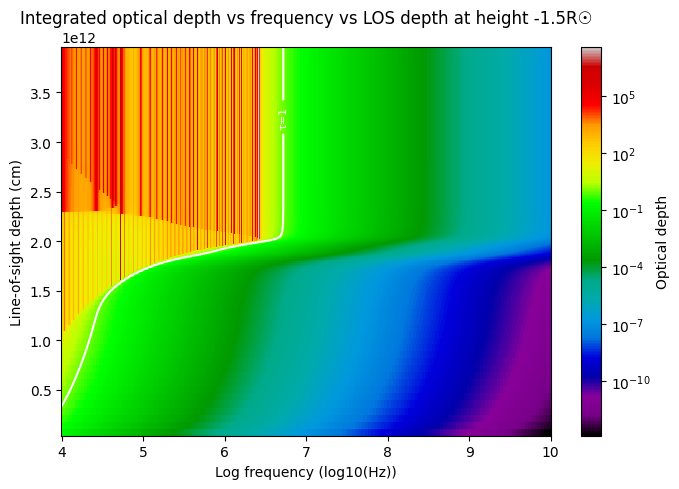

In [176]:
H, W = yya.shape
centeridx = W // 2
height = -1.5
heights = zz[:, centeridx]
target_row = np.argmin(np.abs(heights - height))
rayidx = target_row * W + centeridx

ray_tau_vs_freq = []
depths_cm = None

for v in V:
    taus, depths, _ = radio_integrate_slice(
        temp_rays[:, [rayidx]],
        btot_rays[:, [rayidx]],
        blos_rays[:, [rayidx]],
        ne_rays[:, [rayidx]],
        dray[:, [rayidx]],
        10**v,
        dogyro
    )
    ray_tau_vs_freq.append(taus[:, 0])
    if depths_cm is None:
        depths_cm = depths[:, 0]

ray_tau_vs_freq = np.array(ray_tau_vs_freq)
depths_cm = np.array(depths_cm)

X, Y = np.meshgrid(V, depths_cm, indexing='ij')
Z = ray_tau_vs_freq

plt.figure(figsize=(7, 5))
plt.pcolormesh(
    X, Y, Z,
    shading='auto',
    cmap='nipy_spectral',
    norm=LogNorm()
)
plt.colorbar(label='Optical depth')
c = plt.contour(X, Y, Z, levels=[1.], colors='white', linewidths=1.5)
plt.clabel(c, inline=True, fontsize=8, fmt='τ=%1.0f')
plt.xlabel('Log frequency (log10(Hz))')
plt.ylabel('Line-of-sight depth (cm)')
plt.title(f'Integrated optical depth vs frequency vs LOS depth at height {height}R☉')
plt.tight_layout()
plt.show()